In [1]:
import numpy as np # Upgrade python to do array operations 
import xarray as xr # Let the numpy arrays support metadata and coordinates
import matplotlib.pyplot as plt # to allow plotting
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs # Cartopy allows us to add maps to the plots
import xarray_extras # This has some bonus xarray abilities, such as export to csv
import glob
import pdb

%matplotlib inline

## ) Example of loading one file

Here is an example of how to load one file, plot the geospatial property and also a timeseries averaged over different timescales for 3 different cities. Notice how we have selected the file to represent all data in the decade 2020 to 2030.

In [210]:
UKCP_file='tas_rcp85_land-rcm_uk_12km_01_day_20301201-20401130.nc' #tas is average temperature
UKCP_file_max='tasmax_rcp85_land-rcm_uk_12km_01_day_20301201-20401130.nc' #tasmax is maximum temperature

UKCP_FILE_LAND_MASK='lsm_land-rcm_uk_12km.nc' #this file just has information on where land is
UKCP_regionfile= 'spatial-files/ukcp18-uk-land-region-hires/ukcp18-uk-land-region-hires.shp' #this has information on UK regions

#UKCP_tas_folder ='C:/Users/Dave/Downloads/lsm_land-rcm_uk_12km.nc'

# Define what product you want to look at- if using multiple files. See section 2.
#selection = 'Max'

#if selection == 'Average':
#    filelist_tas=glob.glob('C:/Users/Dave/Documents/Data/UKCP18/Taverage/*.nc')
#elif selection == 'Min':
#    filelist_tas=glob.glob('C:/Users/Dave/Documents/Data/UKCP18/Tmin/*.nc')
#elif selection == 'Max':
#    filelist_tas=glob.glob('C:/Users/Dave/Documents/Data/UKCP18/Tmax/*.nc')    
#elif selection == 'Precip':
#    filelist_tas=glob.glob('C:/Users/Dave/Documents/Data/UKCP18/precip/*.nc')
    

In [211]:
import shapefile   
sf = shapefile.Reader(UKCP_regionfile)

In [212]:
# Use Xarray to load the netcdf files
dat=xr.open_mfdataset(UKCP_file_max) # The actual data we are interested in. In this case, average temperatures
mask=xr.open_dataset(UKCP_FILE_LAND_MASK) # Load the land mask, which allows us to distinguish land from sea

In [213]:
# Preview the Xarray dataframe
# This shows us what is included in the file. This file is a little like a dictionary/phonebook. 
dat

<xarray.Dataset>
Dimensions:                       (ensemble_member: 1, time: 3600,
                                   projection_y_coordinate: 112,
                                   projection_x_coordinate: 82, bnds: 2)
Coordinates:
  * ensemble_member               (ensemble_member) int32 1
  * time                          (time) object 2030-12-01 12:00:00 ... 2040-...
  * projection_y_coordinate       (projection_y_coordinate) float64 -1.02e+05...
  * projection_x_coordinate       (projection_x_coordinate) float64 -2.1e+05 ...
Dimensions without coordinates: bnds
Data variables:
    tasmax                        (ensemble_member, time, projection_y_coordinate, projection_x_coordinate) float32 dask.array<chunksize=(1, 3600, 112, 82), meta=np.ndarray>
    transverse_mercator           int32 ...
    time_bnds                     (time, bnds) object dask.array<chunksize=(3600, 2), meta=np.ndarray>
    projection_y_coordinate_bnds  (projection_y_coordinate, bnds) float64 dask.array<chunksize=(112, 2), meta=np.ndarray>
    projection_x_coordinate_bnds  (projection_x_coordinate, bnds) float64 dask.array<chunksize=(82, 2), meta=np.ndarray>
    ensemble_member_id            (ensemble_member) |S27 dask.array<chunksize=(1,), meta=np.ndarray>
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(112, 82), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(112, 82), meta=np.ndarray>
    month_number                  (time) int32 dask.array<chunksize=(3600,), meta=np.ndarray>
    year                          (time) int32 dask.array<chunksize=(3600,), meta=np.ndarray>
    yyyymmdd                      (time) |S64 dask.array<chunksize=(3600,), meta=np.ndarray>
Attributes: (12/15)
    collection:      land-rcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-04T02:23:23
    domain:          uk
    frequency:       day
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      12km
    scenario:        rcp85
    source:          UKCP18 regional realisation from a set of 12 limited-are...
    title:           UKCP18 land projections - 12km regional climate model, m...
    version:         v20181122
    Conventions:     CF-1.5

In [214]:
# Now we are going to plot one point in time. If you look at the tas entry you will see
# it is a 3D structure. This is because it has coordinates AND time. This data represents
# a daily value. So lets pull out the first entry for all of our coordinates.
x=dat.tasmax[0,600,:,:] #note the first number '0' represents a model, second is a point in time [3600 points in one decade] and the second numbers are x and y coordinates [ONS!!]

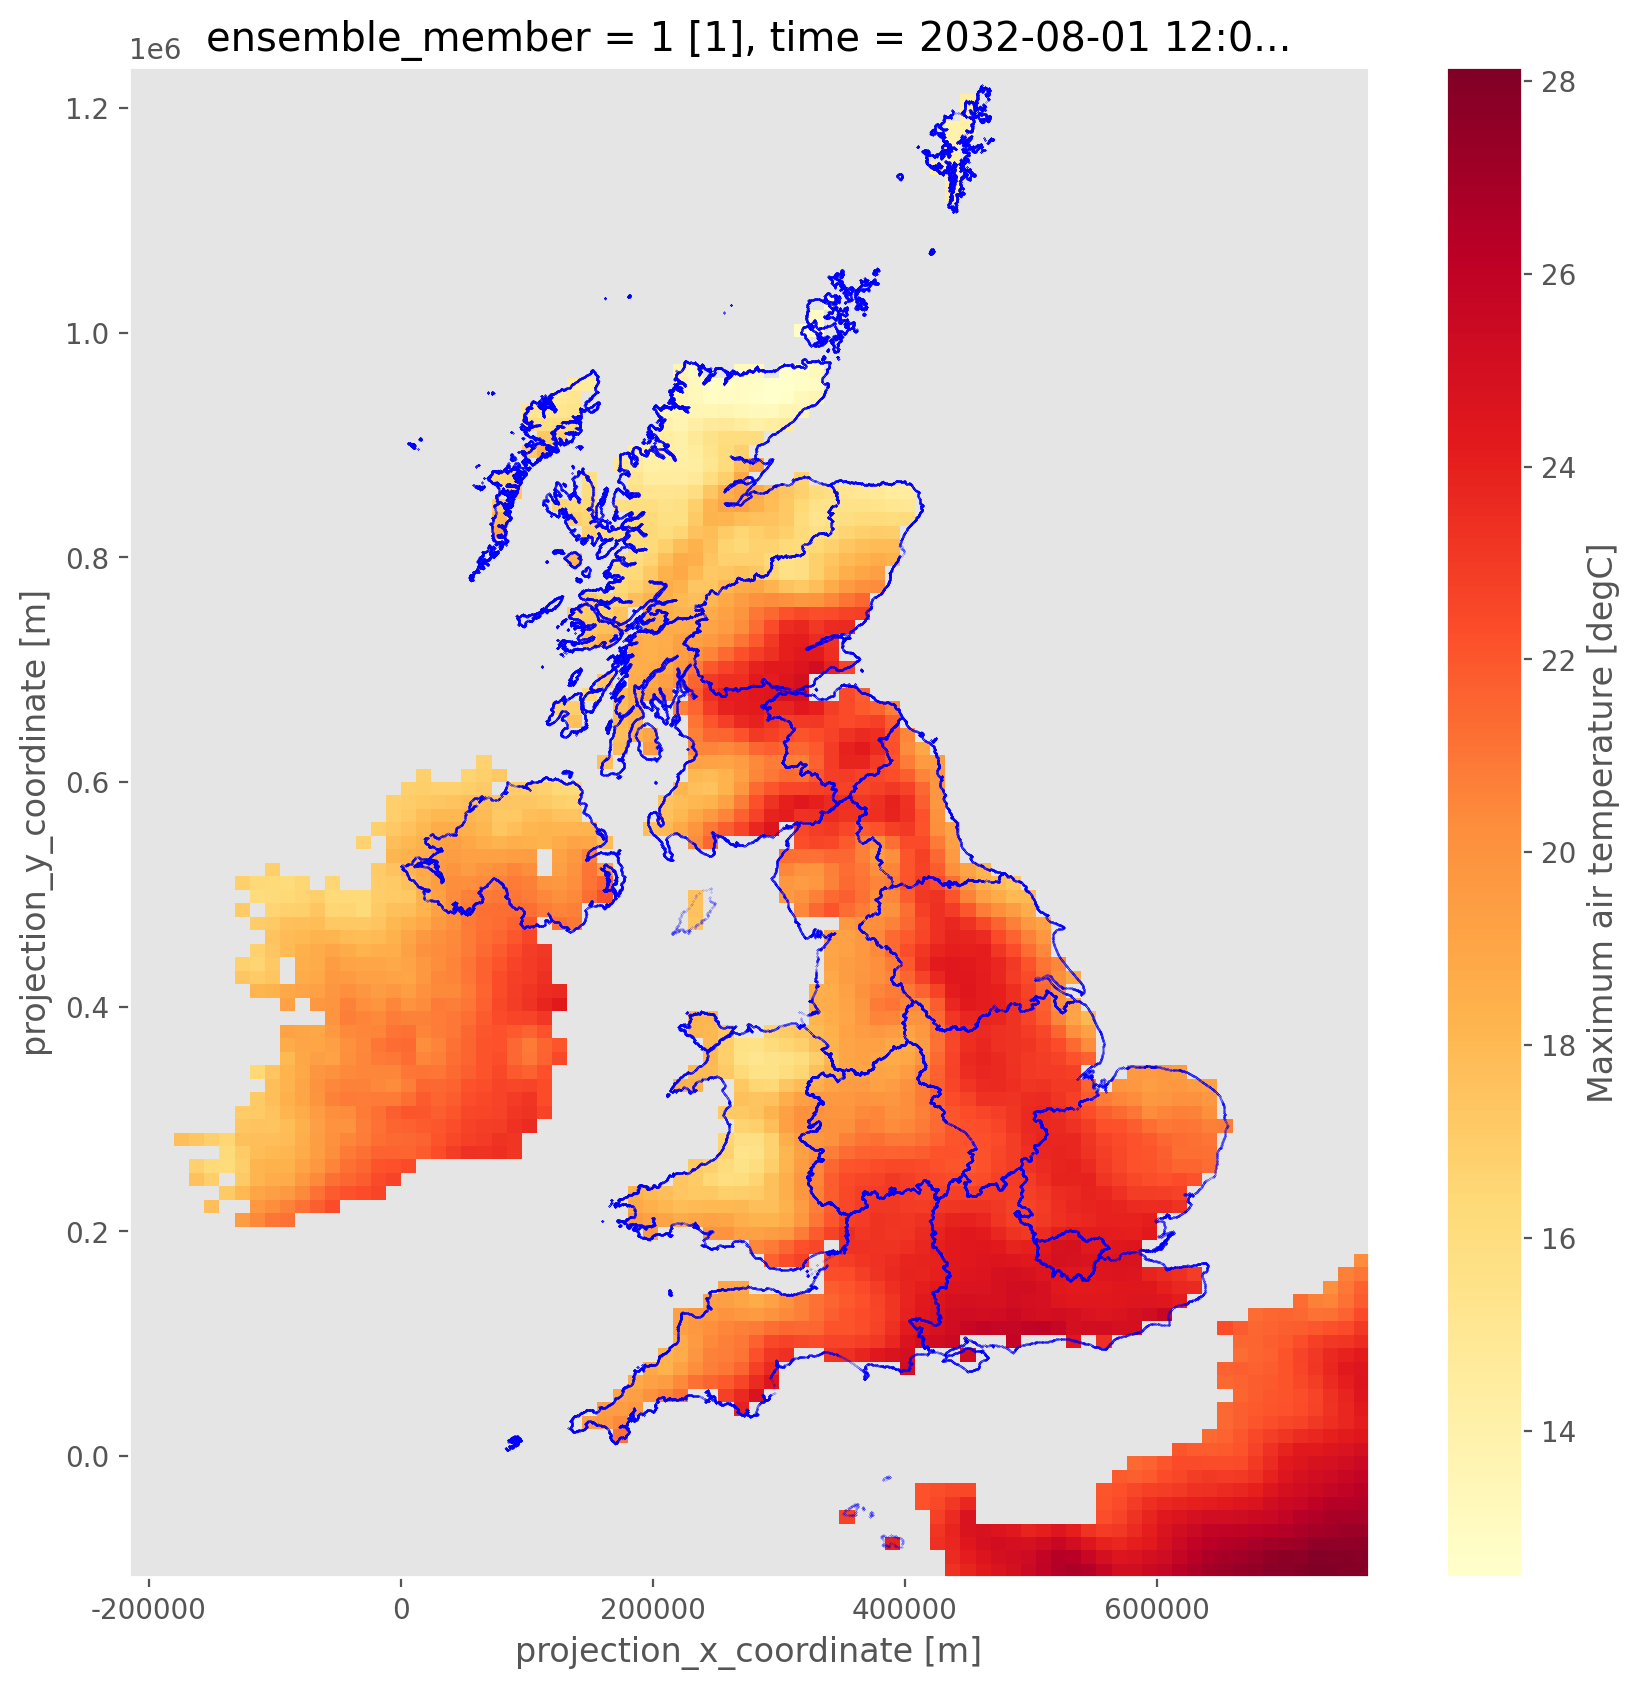

In [215]:
# Now we can visualise the data across the UK
# this first plot shows the temperature data
plt.figure(figsize=[10,10])
diff_lnd=x.where(mask.lsm>0) #actually apply the land-sea mask (called lsm)
diff_lnd.plot(cmap='YlOrRd')

#the second plot just adds regional shapes and plots them
for shape in sf.shapeRecords():
    x_shape = [i[0] for i in shape.shape.points[:]]
    y_shape = [i[1] for i in shape.shape.points[:]]
    plt.scatter(x_shape,y_shape,s=0.005, c='b')
plt.show()


In the following code blocks we are going to specify the location of different cities. These have exact ONS coordiantes. However we are working with fixed gridded climate data. So what I do below is define a box using 4 cells the covers the city area. I then take the average of those 4 blocks. First we extract the x and y coordinates from our xarray variable.

In [177]:
# Extract the coordinate values. To understand what we are doing here, revisit the preview of our entire Xarray and 
# the 'dat' variable
y_coords = dat.projection_y_coordinate.values
x_coords = dat.projection_x_coordinate.values

In [178]:
y_coords.shape

(112,)

Now we can calculate the bounding boxes of our cities.

In [207]:
# --------------------- North West ------------------------------------------------
# lets find where manchester is 
# lat=53.483959; lon=-2.244644
# OS grid ref 384038, 398208
Manchester_xcoords_upper=np.argmax(x_coords>=384038)
Manchester_xcoords_lower=Manchester_xcoords_upper-1

Manchester_ycoords_upper=np.argmax(y_coords>=398208)
Manchester_ycoords_lower=Manchester_ycoords_upper-1

# --------------------- North East ------------------------------------------------
# Newcastle
# 54.97794° N, -1.61162° E
# OS grid ref 425048, 564892
Newcastle_xcoords_upper=np.argmax(x_coords>=425048)
Newcastle_xcoords_lower=Newcastle_xcoords_upper-1

Newcastle_ycoords_upper=np.argmax(y_coords>=564892)
Newcastle_ycoords_lower=Newcastle_ycoords_upper-1


# --------------------- West Midlands  ------------------------------------------------
# Birmingham
# Latitude: 52°28′53″ N Longitude: 1°53′59″ W
# OS grid ref 406689, 286822
Birmingham_xcoords_upper=np.argmax(x_coords>=406689)
Birmingham_xcoords_lower=Birmingham_xcoords_upper-1

Birmingham_ycoords_upper=np.argmax(y_coords>=286822)
Birmingham_ycoords_lower=Birmingham_ycoords_upper-1



<ipython-input-216-6212370b058d>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(384038, 398208,'bo', c='g')
<ipython-input-216-6212370b058d>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(425048, 564892,'bo', c='black')
<ipython-input-216-6212370b058d>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(406907.262,287056.395,'bo', c='purple')


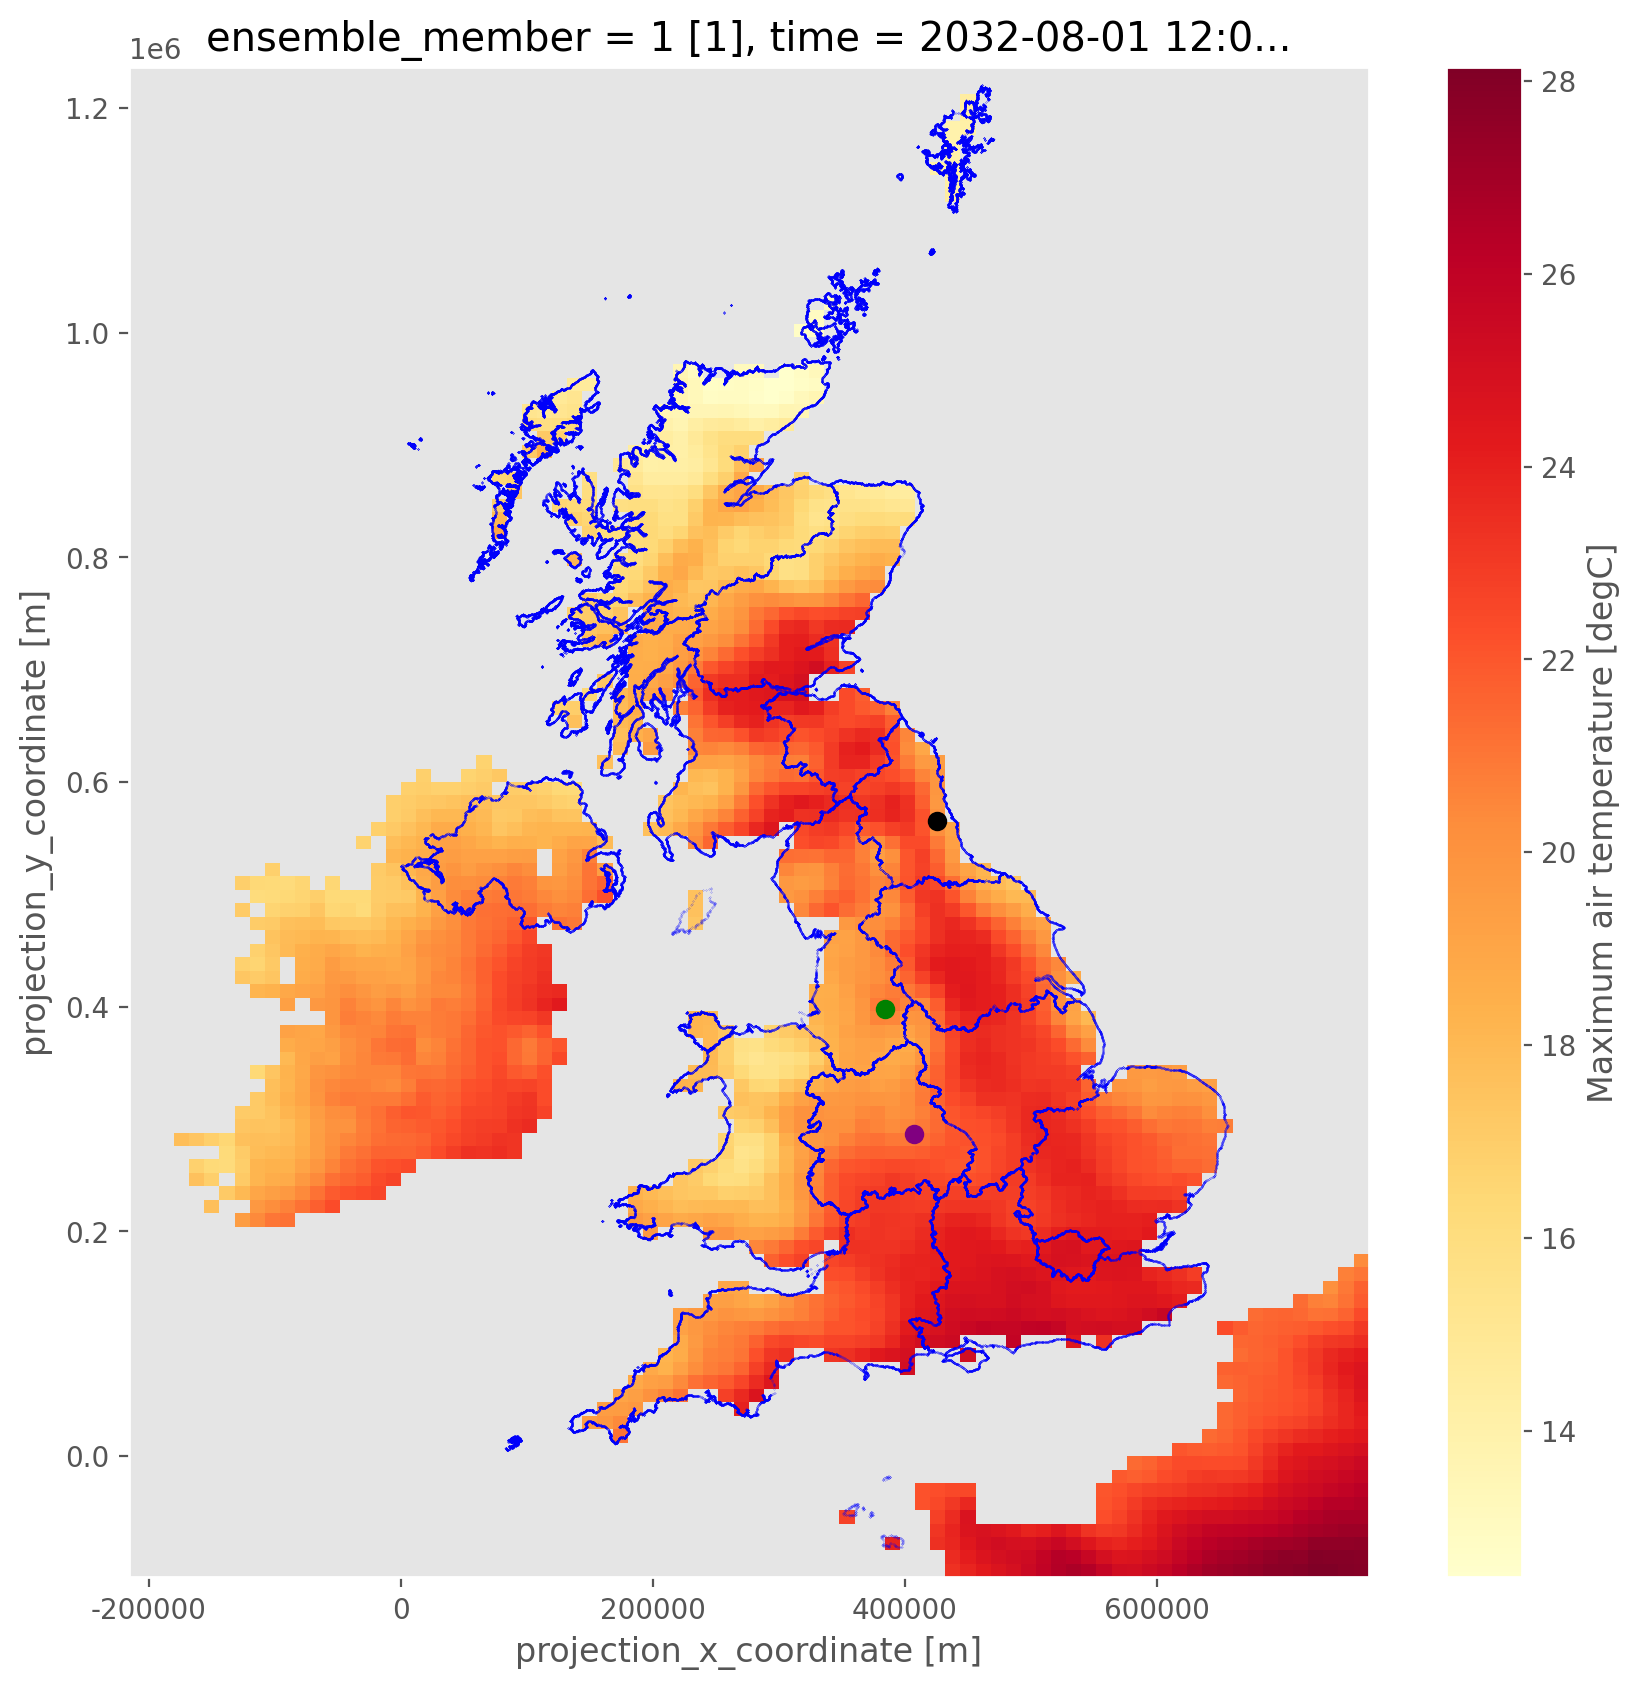

In [216]:
# Lets plot these locations on our map

plt.figure(figsize=[10,10])

#plt.figure(figsize=[10,10])
diff_lnd=x.where(mask.lsm>0) #actually apply the land-sea mask (called lsm)
diff_lnd.plot(cmap='YlOrRd')
ax=plt.gcf().get_axes()
plt.plot(384038, 398208,'bo', c='g')


plt.plot(425048, 564892,'bo', c='black')


plt.plot(406907.262,287056.395,'bo', c='purple')



for shape in sf.shapeRecords():
    x_shape = [i[0] for i in shape.shape.points[:]]
    y_shape = [i[1] for i in shape.shape.points[:]]
    plt.scatter(x_shape,y_shape,s=0.005, c='b')
plt.show()

Now we calculate the average time series of temperatures for our cities as per the below

In [12]:
manchester_data=(dat.tasmax[0,:,Manchester_ycoords_lower,Manchester_xcoords_upper]+
                 dat.tasmax[0,:,Manchester_ycoords_lower,Manchester_xcoords_lower]+
                 dat.tasmax[0,:,Manchester_ycoords_upper,Manchester_xcoords_upper]+
                 dat.tasmax[0,:,Manchester_ycoords_upper,Manchester_xcoords_lower])/4

Birmingham_data = (dat.tasmax[0,:,Birmingham_ycoords_lower,Birmingham_xcoords_upper]+
             dat.tasmax[0,:,Birmingham_ycoords_lower,Birmingham_xcoords_lower]+
             dat.tasmax[0,:,Birmingham_ycoords_upper,Birmingham_xcoords_upper]+
             dat.tasmax[0,:,Birmingham_ycoords_upper,Birmingham_xcoords_lower])/4
        
Newcastle_data = (dat.tasmax[0,:,Newcastle_ycoords_upper,Newcastle_xcoords_upper]+
                  dat.tasmax[0,:,Newcastle_ycoords_upper,Newcastle_xcoords_lower]+
                  dat.tasmax[0,:,Newcastle_ycoords_lower,Newcastle_xcoords_upper]+
                  dat.tasmax[0,:,Newcastle_ycoords_lower,Newcastle_xcoords_lower])/4
                  


You can have a look at the data. Notice how it still exists as an xarray dataset

In [13]:
Newcastle_data

<xarray.DataArray 'tasmax' (time: 3600)>
dask.array<truediv, shape=(3600,), dtype=float32, chunksize=(3600,), chunktype=numpy.ndarray>
Coordinates:
    ensemble_member          int32 1
  * time                     (time) object 2020-12-01 12:00:00 ... 2030-11-30...
    projection_y_coordinate  float64 5.58e+05

If we want to plot timeseries, or easily calculate seasonal means etc we want to pull out the time of each prediction. We have daily predictions in this example, so we extract from 'dat' the year, month and day. We are going to combine this information in a pandas dataframe to calculate a timestamp. Notice how this is slightly different to how we extract year etc in Pandas.

In [14]:
year=dat.time.dt.year.values
month=dat.time.dt.month.values
day=dat.time.dt.day.values

Im now going to put all of the city data, and time data, into one 2D numpy array. This array will then be used to construct a dataframe.

In [15]:
main_list = np.concatenate([year[:, np.newaxis],month[:, np.newaxis],day[:, np.newaxis],manchester_data.values[:, np.newaxis],Birmingham_data.values[:, np.newaxis], Newcastle_data.values[:, np.newaxis]],axis=1)


In [16]:
data=main_list
data.shape

(3600, 6)

Now lets construct a dataframe. Once we have the timestamp as the index of our dataframe, we can calculate monthly means etc. 

In [17]:
#Combine all values into a dataframe
import pandas as pd

df = pd.DataFrame(data, columns = ['year', 'month','day','Manchester','Birmingham','Newcastle'])
df = df.astype({'year':'int', 'month':'int', 'day':'int'}) 

cols=['year','month','day']
df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d',errors='coerce')
df=df.set_index('date')

In the folllowing, we resample to a monthly average [from the original daily data].

In [18]:
df1=df[['Manchester','Birmingham','Newcastle']].resample('M').mean()


In [19]:
df1.index

DatetimeIndex(['2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31',
               '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-31',
               '2021-08-31', '2021-09-30',
               ...
               '2030-02-28', '2030-03-31', '2030-04-30', '2030-05-31',
               '2030-06-30', '2030-07-31', '2030-08-31', '2030-09-30',
               '2030-10-31', '2030-11-30'],
              dtype='datetime64[ns]', name='date', length=120, freq=None)

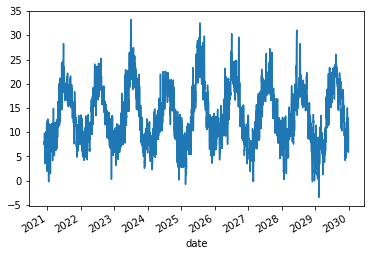

In [20]:
start_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2030-01-01', format='%Y-%m-%d')
df['Manchester'].loc[(df.index > start_date) & (df.index < end_date)].plot()
plt.show()

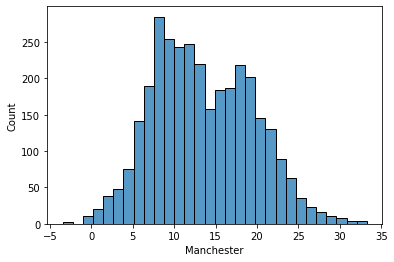

In [21]:
import seaborn as sns
sns.histplot(data=df.loc[(df.index > start_date) & (df.index < end_date)], x="Manchester")
plt.show()

## Example load all files into one dataframe. Then produce decadal distribution of maximum temperatures

In the code below we loop through all available files and load then into seperate dataframes, basically repeating the operation above. Following this, we then concatenate all of those dataframes into one before extracting decadal distributions. For distributions we use both histograms and boxplots. Im taking some of the code from above and repeating below.

In [241]:
# Define what product you want to look at- if using multiple files. See section 2.
selection = 'Precip'

if selection == 'Average':
    filelist_tas=glob.glob('/Users/liuzhenrui/Desktop/Dissertation/UKCP18/Taverage/*.nc')
elif selection == 'Min':
    filelist_tas=glob.glob('/Users/liuzhenrui/Desktop/Dissertation/UKCP18/Tmin/*.nc')
elif selection == 'Max':
    filelist_tas=glob.glob('/Users/liuzhenrui/Desktop/Dissertation/UKCP18/Tmax/*.nc')    
elif selection == 'Precip':
    filelist_tas=glob.glob('/Users/liuzhenrui/Desktop/Dissertation/UKCP18/precip/*.nc')
    
#we are going to keep a record of all the dictionaries in a list at first
dict_list=[]
for file in filelist_tas:
    dat=xr.open_mfdataset(file) # The actual data we are interested in. In this case, average temperatures
    
    manchester_data=(dat.pr[0,:,Manchester_ycoords_lower,Manchester_xcoords_upper]+
                 dat.pr[0,:,Manchester_ycoords_lower,Manchester_xcoords_lower]+
                 dat.pr[0,:,Manchester_ycoords_upper,Manchester_xcoords_upper]+
                 dat.pr[0,:,Manchester_ycoords_upper,Manchester_xcoords_lower])/4

    Birmingham_data = (dat.pr[0,:,Birmingham_ycoords_lower,Birmingham_xcoords_upper]+
             dat.pr[0,:,Birmingham_ycoords_lower,Birmingham_xcoords_lower]+
             dat.pr[0,:,Birmingham_ycoords_upper,Birmingham_xcoords_upper]+
             dat.pr[0,:,Birmingham_ycoords_upper,Birmingham_xcoords_lower])/4
    
    Newcastle_data = (dat.pr[0,:,Newcastle_ycoords_upper,Newcastle_xcoords_upper]+
                  dat.pr[0,:,Newcastle_ycoords_upper,Newcastle_xcoords_lower]+
                  dat.pr[0,:,Newcastle_ycoords_lower,Newcastle_xcoords_upper]+
                  dat.pr[0,:,Newcastle_ycoords_lower,Newcastle_xcoords_lower])/4
    

    year=dat.time.dt.year.values
    month=dat.time.dt.month.values
    day=dat.time.dt.day.values
    
    main_list = np.concatenate([year[:, np.newaxis],month[:, np.newaxis],day[:, np.newaxis],manchester_data.values[:, np.newaxis],Birmingham_data.values[:, np.newaxis],Newcastle_data.values[:, np.newaxis]],axis=1)
    data=main_list
    df = pd.DataFrame(data, columns = ['year', 'month','day','man_pr','bir_pr','new_pr'])
    df = df.astype({'year':'int', 'month':'int', 'day':'int'}) 

    cols=['year','month','day']
    df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d',errors='coerce')
    df=df.set_index('date')
    
    dict_list.append(df)
    
large_dataframe= pd.concat(dict_list)
    

    

In [233]:
large_dataframe_max = large_dataframe[large_dataframe.year >= 1981]

In [236]:
large_dataframe_avg = large_dataframe[large_dataframe.year >= 1981]

In [240]:
large_dataframe_min = large_dataframe[large_dataframe.year >= 1981]

In [242]:
large_dataframe_pr = large_dataframe[large_dataframe.year >= 1981]

In [248]:
large_dataframe_max.reset_index(inplace=True)

In [259]:
large_dataframe_max

,date,year,month,day,man_max,bir_max,new_max
0,2030-12-01,2030,12,1,6.589074,7.099314,6.694527
1,2030-12-02,2030,12,2,7.531672,7.805592,8.930920
2,2030-12-03,2030,12,3,9.593786,10.177877,8.790504
3,2030-12-04,2030,12,4,7.732744,7.246864,8.566730
4,2030-12-05,2030,12,5,8.362719,7.932727,8.499326
...,...,...,...,...,...,...,...
35965,2060-11-26,2060,11,26,6.482309,7.154745,6.299595
35966,2060-11-27,2060,11,27,5.596263,5.442601,4.479141
35967,2060-11-28,2060,11,28,5.247433,5.768433,5.865978
35968,2060-11-29,2060,11,29,5.233734,6.245536,7.257345


In [264]:
dt = pd.merge(large_dataframe_max, large_dataframe_min.loc[:,['date','man_min','bir_min','new_min']],on='date',how='left')

In [262]:
dt = pd.merge(dt, large_dataframe_avg.loc[:,['date','man_avg','bir_avg','new_avg']],on='date',how='left')

In [266]:
large_dataframe_min.loc[:,['date','man_min','bir_min','new_min']]

,date,man_min,bir_min,new_min
0,1990-12-01,-0.292701,0.124943,1.153770
1,1990-12-02,-3.756351,-1.561012,-1.418777
2,1990-12-03,3.845803,3.364040,5.109035
3,1990-12-04,5.880041,6.782277,3.983124
4,1990-12-05,8.422891,10.245434,6.296820
...,...,...,...,...
35965,2060-11-26,3.577855,3.602292,1.386133
35966,2060-11-27,2.187490,3.540988,0.780373
35967,2060-11-28,1.063210,2.174376,0.965514
35968,2060-11-29,-0.310032,1.615056,4.621992


In [271]:
dt = large_dataframe_max.merge(large_dataframe_min.loc[:,['date','man_min','bir_min','new_min']],on='date',how='left')

In [294]:
large_dataframe_pr = large_dataframe_pr.loc[:,['date','man_pr','bir_pr','new_pr']]

In [295]:
large_dataframe_pr

,date,man_pr,bir_pr,new_pr
0,1990-12-01,0.006835,0.005998,1.004823e-01
1,1990-12-02,6.635946,6.276577,4.684137e+00
2,1990-12-03,2.435697,2.196458,3.645688e-01
3,1990-12-04,9.724846,0.291889,1.180843e+00
4,1990-12-05,6.544029,0.015334,8.007380e-02
...,...,...,...,...
35965,2060-11-26,1.101882,0.030351,3.691392e-02
35966,2060-11-27,0.689819,11.545986,1.428464e-08
35967,2060-11-28,0.006410,0.002858,6.763595e-01
35968,2060-11-29,0.067630,0.024912,9.021096e-01


In [296]:
large_dataframe_pr.to_csv('pr.csv')

In [275]:
dt

,date,year,month,day,man_max,bir_max,new_max,man_min,bir_min,new_min
0,2030-12-01,2030,12,1,6.589074,7.099314,6.694527,4.288211,5.743685,0.911298
1,2030-12-02,2030,12,2,7.531672,7.805592,8.930920,5.613256,4.388468,6.410170
2,2030-12-03,2030,12,3,9.593786,10.177877,8.790504,5.359694,4.381751,4.786203
3,2030-12-04,2030,12,4,7.732744,7.246864,8.566730,5.953942,5.469736,6.370528
4,2030-12-05,2030,12,5,8.362719,7.932727,8.499326,4.876895,4.261723,3.496682
...,...,...,...,...,...,...,...,...,...,...
66415,2060-11-26,2060,11,26,6.482309,7.154745,6.299595,3.577855,3.602292,1.386133
66416,2060-11-27,2060,11,27,5.596263,5.442601,4.479141,2.187490,3.540988,0.780373
66417,2060-11-28,2060,11,28,5.247433,5.768433,5.865978,1.063210,2.174376,0.965514
66418,2060-11-29,2060,11,29,5.233734,6.245536,7.257345,-0.310032,1.615056,4.621992


In [258]:
large_dataframe_pr.loc[:,['date','man_pr','bir_pr','new_pr']]

,date,man_pr,bir_pr,new_pr
0,1990-12-01,0.006835,0.005998,1.004823e-01
1,1990-12-02,6.635946,6.276577,4.684137e+00
2,1990-12-03,2.435697,2.196458,3.645688e-01
3,1990-12-04,9.724846,0.291889,1.180843e+00
4,1990-12-05,6.544029,0.015334,8.007380e-02
...,...,...,...,...
35965,2060-11-26,1.101882,0.030351,3.691392e-02
35966,2060-11-27,0.689819,11.545986,1.428464e-08
35967,2060-11-28,0.006410,0.002858,6.763595e-01
35968,2060-11-29,0.067630,0.024912,9.021096e-01


In [255]:
pd.merge(dt,large_dataframe_pr.loc[:,['date','man_pr','bir_pr','new_pr']],on='date',how='inner')

KeyboardInterrupt: 

In [90]:
start_date_1 = pd.to_datetime('2000-01-01', format='%Y-%m-%d')
end_date_1 = pd.to_datetime('2010-01-01', format='%Y-%m-%d')

start_date_2 = pd.to_datetime('2020-01-01', format='%Y-%m-%d')
end_date_2 = pd.to_datetime('2030-01-01', format='%Y-%m-%d')

start_date_3 = pd.to_datetime('2040-01-01', format='%Y-%m-%d')
end_date_3 = pd.to_datetime('2050-01-01', format='%Y-%m-%d')

In [91]:
df_decadal_1=large_dataframe.loc[(large_dataframe.index > start_date_1) & (large_dataframe.index < end_date_1)]
df_decadal_1['Decade']='2000-2010'
df_decadal_2=large_dataframe.loc[(large_dataframe.index > start_date_2) & (large_dataframe.index < end_date_2)]
df_decadal_2['Decade']='2020-2030'
df_decadal_3=large_dataframe.loc[(large_dataframe.index > start_date_3) & (large_dataframe.index < end_date_3)]
df_decadal_3['Decade']='2040-2050'
large_dataframe_subset=pd.concat([df_decadal_1, df_decadal_2], axis=0)
large_dataframe_subset=pd.concat([large_dataframe_subset, df_decadal_3], axis=0)


<ipython-input-91-34338925d05f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_decadal_1['Decade']='2000-2010'
<ipython-input-91-34338925d05f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_decadal_2['Decade']='2020-2030'
<ipython-input-91-34338925d05f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [92]:
large_dataframe_subset

,year,month,day,Manchester,Birmingham,Newcastle,Decade
date,,,,,,,
2000-12-01,2000,12,1,6.118318,6.203269,8.005754,2000-2010
2000-12-02,2000,12,2,11.056015,10.821216,10.031655,2000-2010
2000-12-03,2000,12,3,8.153565,8.435384,7.900453,2000-2010
2000-12-04,2000,12,4,10.192201,10.551811,8.974519,2000-2010
2000-12-05,2000,12,5,9.187515,10.238102,8.979195,2000-2010
...,...,...,...,...,...,...,...
2049-12-26,2049,12,26,7.942844,8.112444,7.902119,2040-2050
2049-12-27,2049,12,27,9.796538,9.833744,9.567911,2040-2050
2049-12-28,2049,12,28,9.009715,9.408737,6.446212,2040-2050


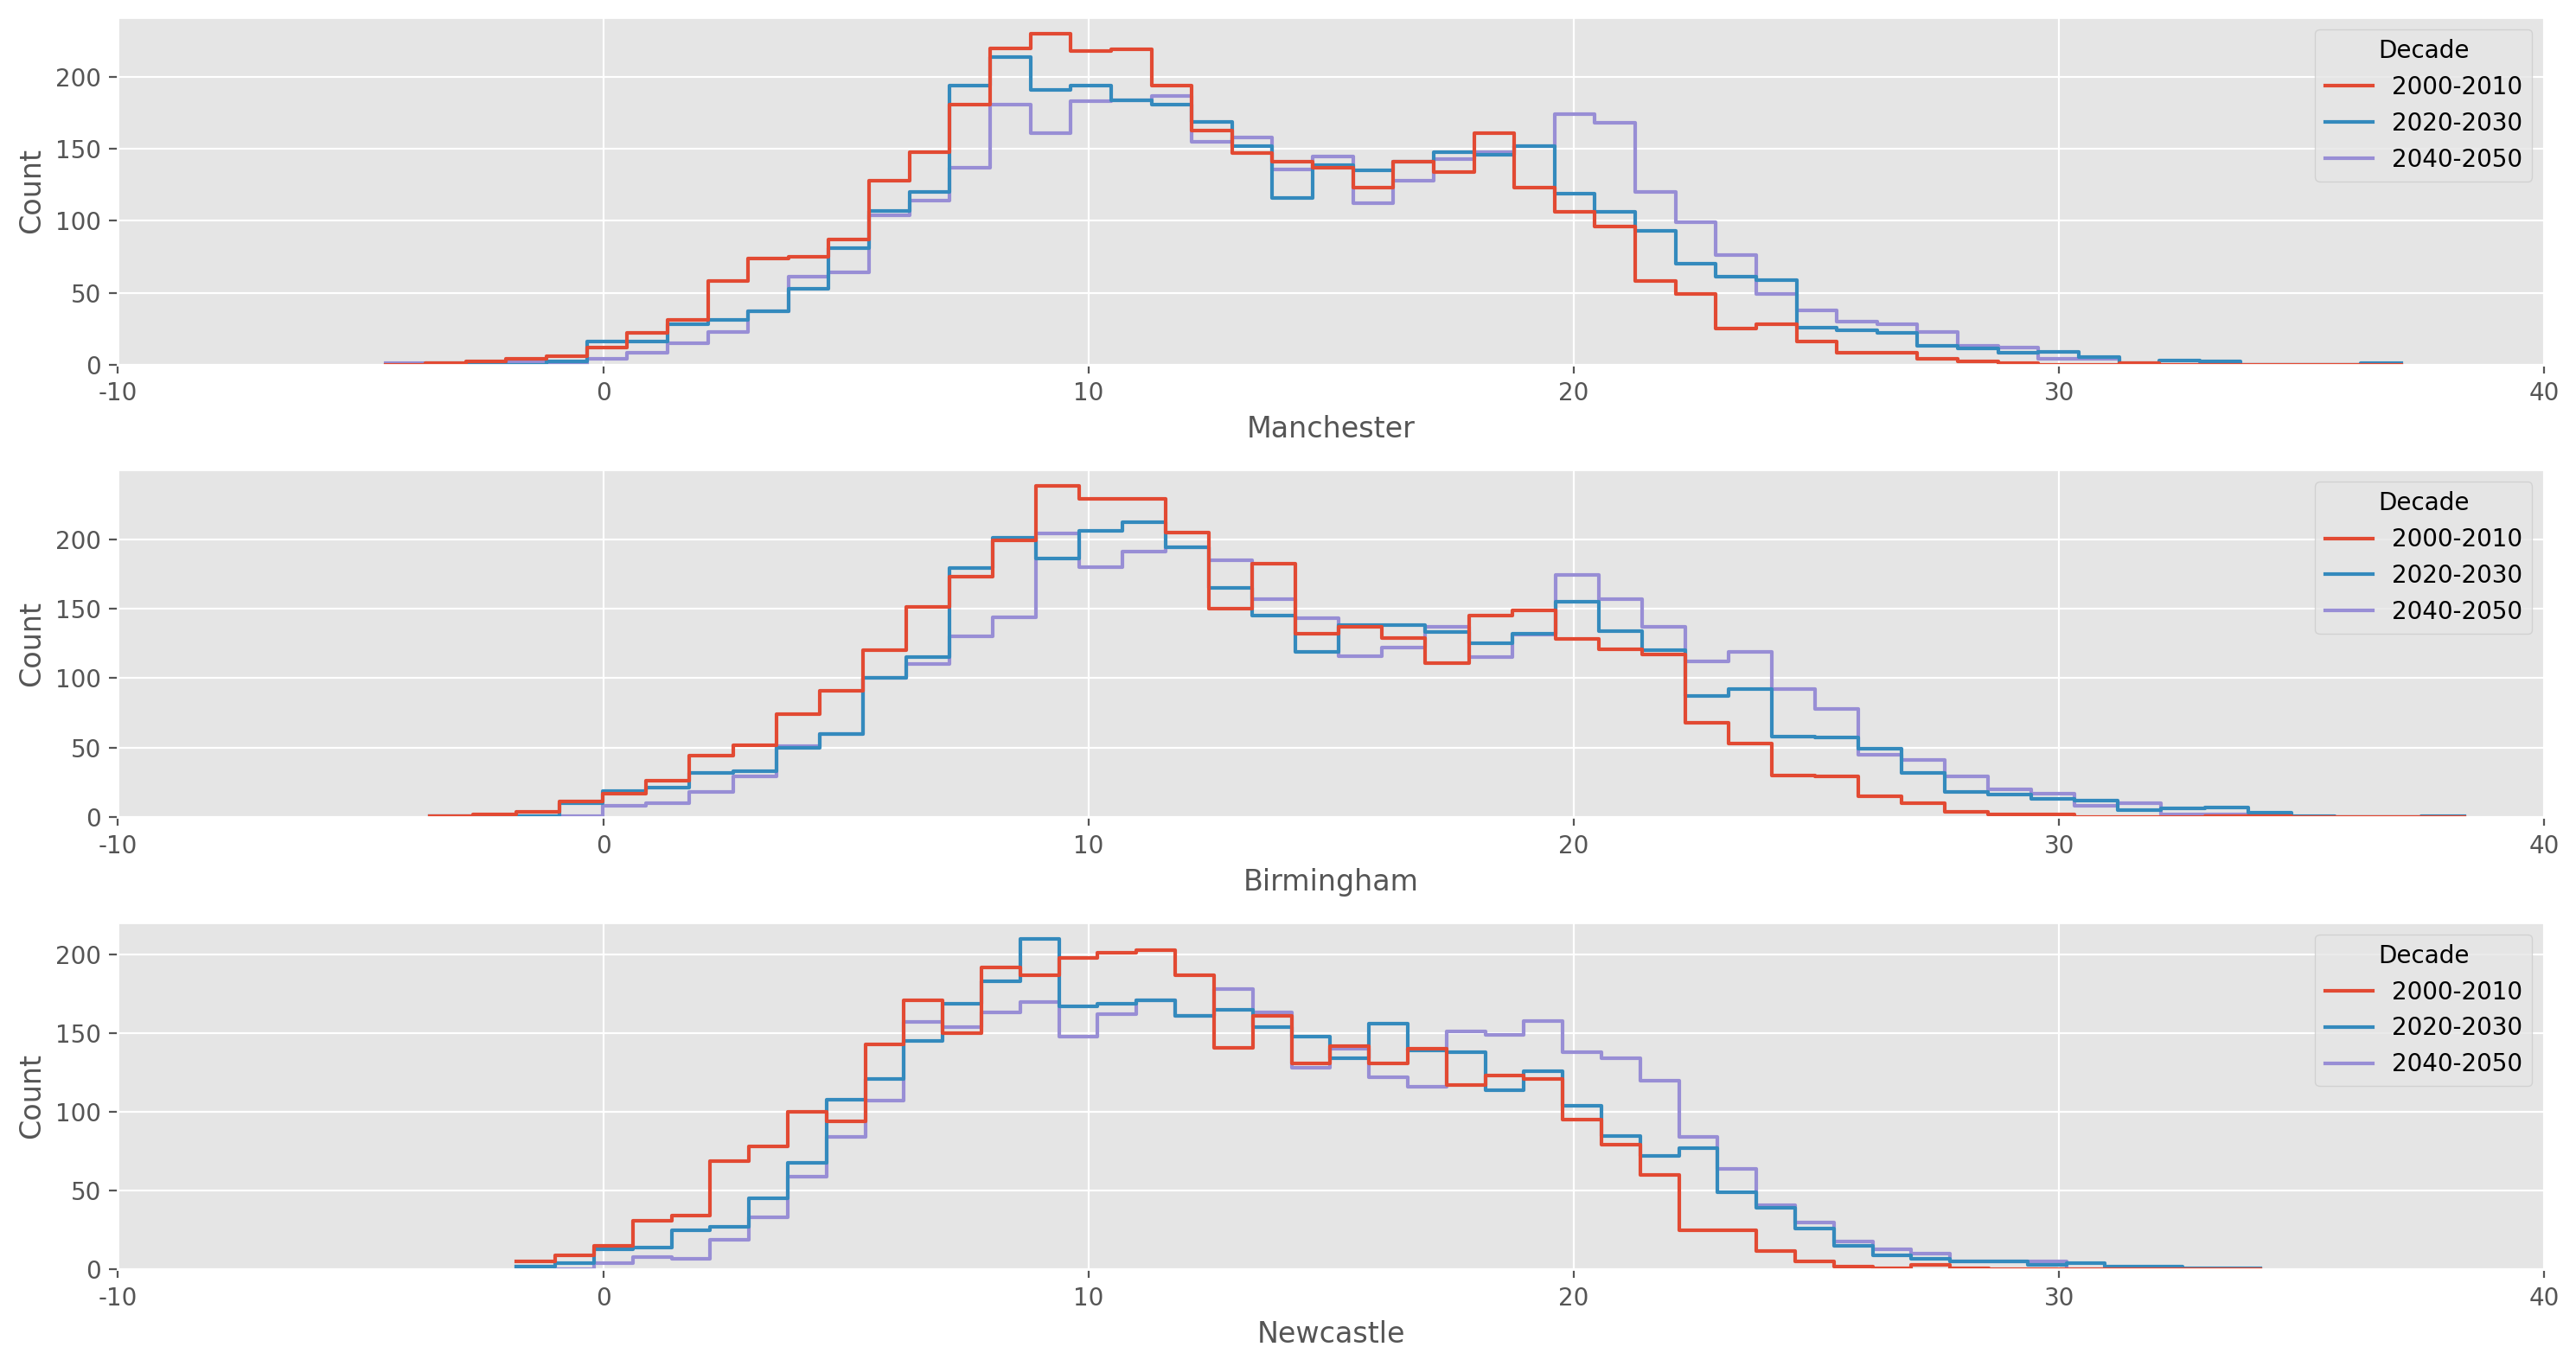

In [95]:
#Now we can plot the data
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 8))
sns.histplot(large_dataframe_subset, x="Manchester", hue="Decade", element="step", fill=False, ax=ax[0])
sns.histplot(large_dataframe_subset, x="Birmingham", hue="Decade", element="step",fill=False, ax=ax[1])
sns.histplot(large_dataframe_subset, x="Newcastle", hue="Decade", element="step",fill=False, ax=ax[2])
ax[0].set_xlim(-10, 40)
ax[1].set_xlim(-10, 40)
ax[2].set_xlim(-10, 40)
plt.tight_layout()
plt.savefig('extreme_weather.pdf')

What if we just wanted to look at summer months, taking June through to end of August? We can do that below.

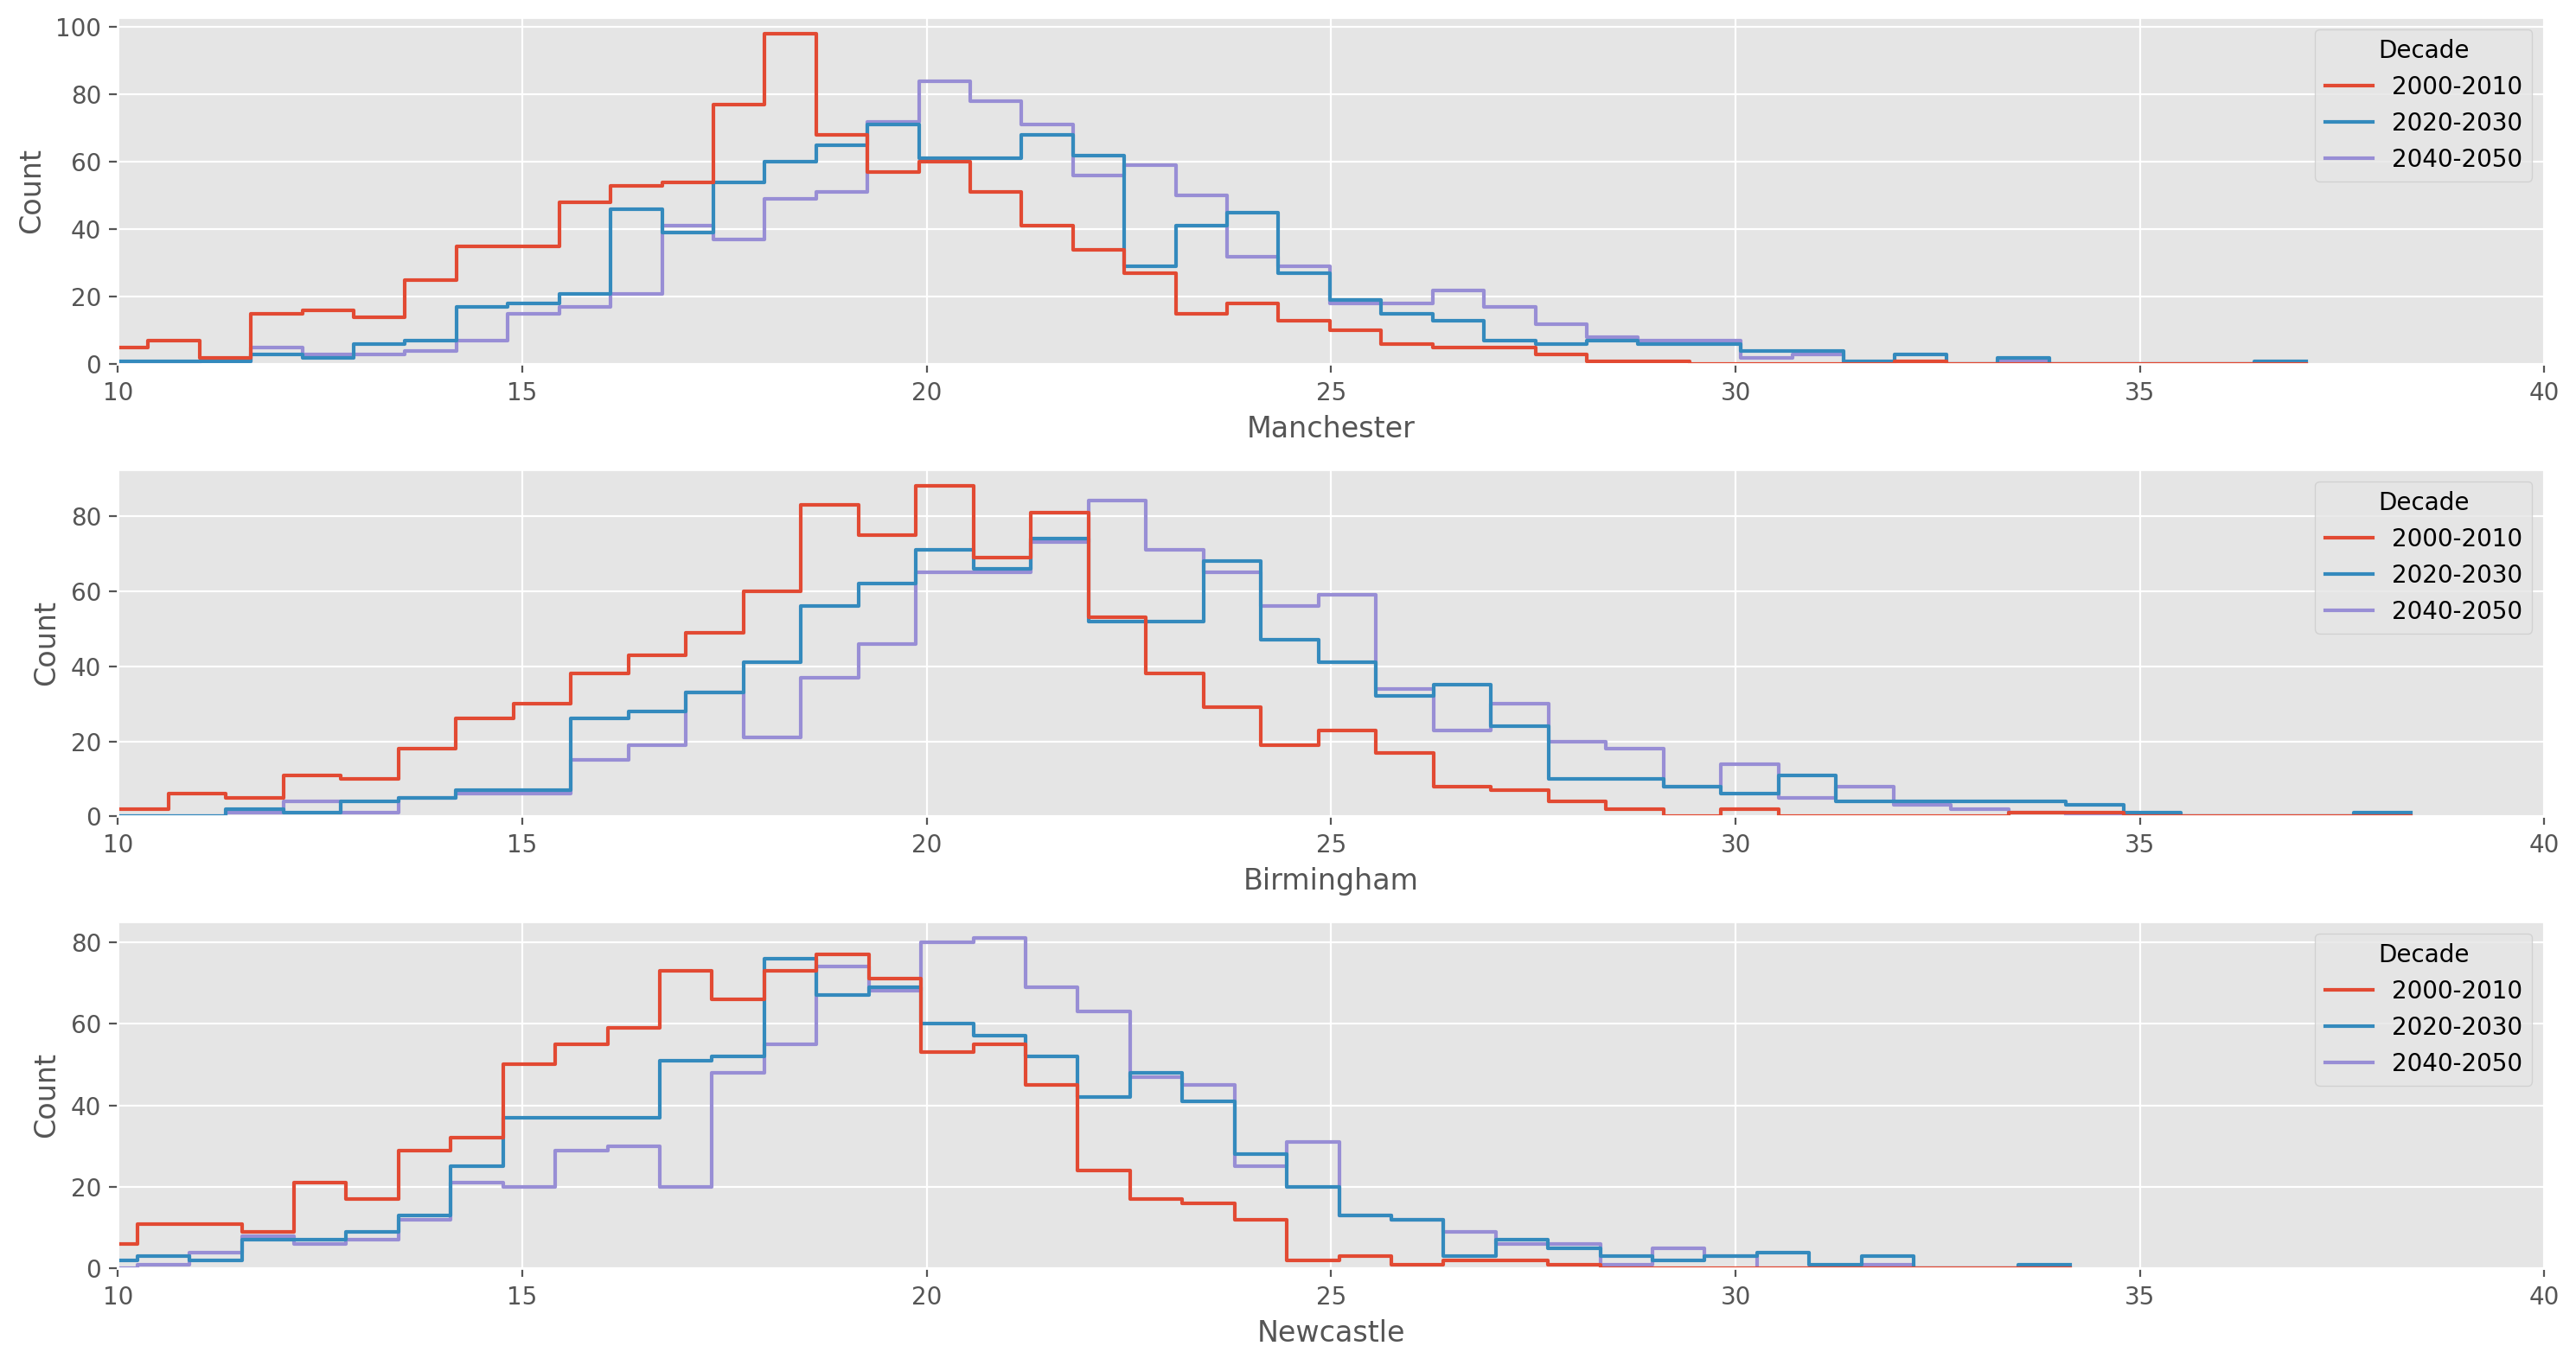

In [96]:
#Now we can plot the data
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 8))
sns.histplot(large_dataframe_subset.loc[(large_dataframe_subset.month >= 6) & (large_dataframe_subset.month <= 8)], x="Manchester", hue="Decade", element="step", fill=False, ax=ax[0])
sns.histplot(large_dataframe_subset.loc[(large_dataframe_subset.month >= 6) & (large_dataframe_subset.month <= 8)], x="Birmingham", hue="Decade", element="step",fill=False, ax=ax[1])
sns.histplot(large_dataframe_subset.loc[(large_dataframe_subset.month >= 6) & (large_dataframe_subset.month <= 8)], x="Newcastle", hue="Decade", element="step",fill=False, ax=ax[2])
ax[0].set_xlim(10, 40)
ax[1].set_xlim(10, 40)
ax[2].set_xlim(10, 40)
plt.tight_layout()
plt.savefig('summermonth_maxtem.pdf')

In [29]:
death_df = pd.read_csv('death.csv')

In [30]:
death_df

,time,Region_Name,Daily_Deaths,sex_rate,death_under65,death_65_74,death_75_84,death_over85
0,1981-01-01,North East,108,1.30,31,28,38,11
1,1981-01-01,Yorkshire and The Humber,164,1.10,39,47,53,25
2,1981-01-01,South West,203,0.99,38,51,70,44
3,1981-01-01,London,245,1.15,54,71,83,37
4,1981-01-01,South East,261,0.93,58,59,83,61
...,...,...,...,...,...,...,...,...
145595,2020-12-31,Yorkshire and The Humber,177,1.30,33,31,47,66
145596,2020-12-31,North West,264,1.10,47,44,78,95
145597,2020-12-31,North East,81,1.19,8,14,25,34
145598,2020-12-31,South West,192,1.13,16,19,53,104


In [31]:
death_df_ne = death_df[death_df.Region_Name == 'North East']
death_df_ne = death_df_ne.rename(columns={'time':'date'})

In [317]:
start_date_4 = pd.to_datetime('1981-01-01', format='%Y-%m-%d')
end_date_4 = pd.to_datetime('2060-01-01', format='%Y-%m-%d')

In [318]:
large_dataframe_max

,date,year,month,day,man_max,bir_max,new_max
0,2030-12-01,2030,12,1,6.589074,7.099314,6.694527
1,2030-12-02,2030,12,2,7.531672,7.805592,8.930920
2,2030-12-03,2030,12,3,9.593786,10.177877,8.790504
3,2030-12-04,2030,12,4,7.732744,7.246864,8.566730
4,2030-12-05,2030,12,5,8.362719,7.932727,8.499326
...,...,...,...,...,...,...,...
35965,2060-11-26,2060,11,26,6.482309,7.154745,6.299595
35966,2060-11-27,2060,11,27,5.596263,5.442601,4.479141
35967,2060-11-28,2060,11,28,5.247433,5.768433,5.865978
35968,2060-11-29,2060,11,29,5.233734,6.245536,7.257345


In [333]:
train_df = large_dataframe_pr.loc[(large_dataframe_pr['date'] >= start_date_4) & (large_dataframe_pr['date'] < end_date_4)]

In [34]:
train_df = train_df.sort_values(by = 'date', ascending = True)
train_df_new = train_df.loc[:, ['year','month','day','Newcastle']]
train_df_new = train_df_new.reset_index()
train_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14330 entries, 0 to 14329
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       14330 non-null  datetime64[ns]
 1   year       14330 non-null  int64         
 2   month      14330 non-null  int64         
 3   day        14330 non-null  int64         
 4   Newcastle  14330 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 559.9 KB


In [334]:
train_df = train_df.sort_values(by='date')

In [335]:
train_df

,date,man_pr,bir_pr,new_pr
3600,1981-01-01,7.552406,0.239028,0.223341
3601,1981-01-02,0.000153,0.205488,0.000372
3602,1981-01-03,1.571437,0.230137,0.005413
3603,1981-01-04,0.301938,0.183753,0.004777
3604,1981-01-05,14.465652,5.484456,6.288929
...,...,...,...,...
35635,2059-12-26,0.141942,0.518378,0.062099
35636,2059-12-27,10.320499,6.628020,3.517229
35637,2059-12-28,32.056690,10.885844,41.328205
35638,2059-12-29,13.612236,13.197613,3.940133


In [336]:
train_df.to_csv('pr.csv')

In [35]:
death_df_ne['date'] = pd.to_datetime(death_df_ne.date)

In [36]:
death_df_ne.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14560 entries, 0 to 145597
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           14560 non-null  datetime64[ns]
 1   Region_Name    14560 non-null  object        
 2   Daily_Deaths   14560 non-null  int64         
 3   sex_rate       14560 non-null  float64       
 4   death_under65  14560 non-null  int64         
 5   death_65_74    14560 non-null  int64         
 6   death_75_84    14560 non-null  int64         
 7   death_over85   14560 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 1023.8+ KB


In [37]:
newcastle_train = pd.merge(death_df_ne, train_df_new, on='date', how='left')
newcastle_train = newcastle_train.rename(columns={'Newcastle':'max_temperature'})
newcastle_train = newcastle_train.loc[:, ['date','Daily_Deaths','sex_rate','death_under65','death_65_74','death_75_84',
                                         'death_over85','max_temperature']]
newcastle_train['year'] = newcastle_train.date.dt.year
newcastle_train['month'] = newcastle_train.date.dt.month
newcastle_train['day'] = newcastle_train.date.dt.day
newcastle_train

,date,Daily_Deaths,sex_rate,death_under65,death_65_74,death_75_84,death_over85,max_temperature,year,month,day
0,1981-01-01,108,1.30,31,28,38,11,4.549093,1981,1,1
1,1981-01-02,112,1.00,31,26,34,21,0.061612,1981,1,2
2,1981-01-03,113,0.88,26,21,45,21,2.300846,1981,1,3
3,1981-01-04,95,0.79,30,20,32,13,6.150383,1981,1,4
4,1981-01-05,101,0.94,27,25,30,19,7.675478,1981,1,5
...,...,...,...,...,...,...,...,...,...,...,...
14555,2020-12-26,103,1.19,17,14,33,39,6.416586,2020,12,26
14556,2020-12-27,106,0.80,15,24,33,34,4.718904,2020,12,27
14557,2020-12-28,115,1.09,16,26,36,37,10.461271,2020,12,28
14558,2020-12-30,81,1.38,11,14,30,26,5.054269,2020,12,30


In [38]:
newcastle_train.index = newcastle_train.date

In [39]:
newcastle_train = newcastle_train.iloc[:, 1:]

In [40]:
newcastle_train['death_over65'] = newcastle_train.Daily_Deaths - newcastle_train.death_under65

In [41]:
newcastle_train

,Daily_Deaths,sex_rate,death_under65,death_65_74,death_75_84,death_over85,max_temperature,year,month,day,death_over65
date,,,,,,,,,,,
1981-01-01,108,1.30,31,28,38,11,4.549093,1981,1,1,77
1981-01-02,112,1.00,31,26,34,21,0.061612,1981,1,2,81
1981-01-03,113,0.88,26,21,45,21,2.300846,1981,1,3,87
1981-01-04,95,0.79,30,20,32,13,6.150383,1981,1,4,65
1981-01-05,101,0.94,27,25,30,19,7.675478,1981,1,5,74
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,103,1.19,17,14,33,39,6.416586,2020,12,26,86
2020-12-27,106,0.80,15,24,33,34,4.718904,2020,12,27,91
2020-12-28,115,1.09,16,26,36,37,10.461271,2020,12,28,99


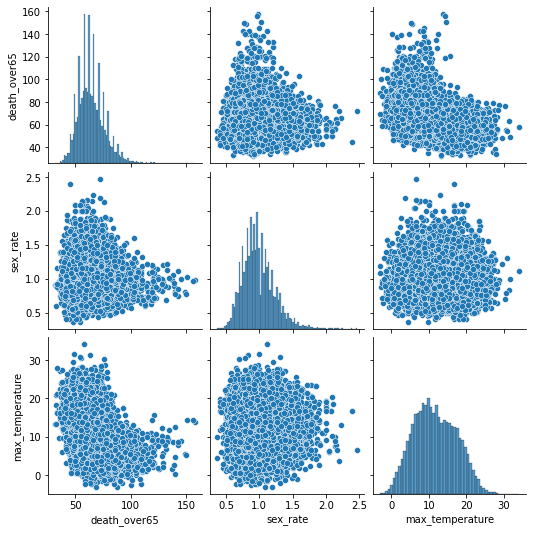

In [42]:
sns.pairplot(newcastle_train.loc[:, ['death_over65','sex_rate','max_temperature']])

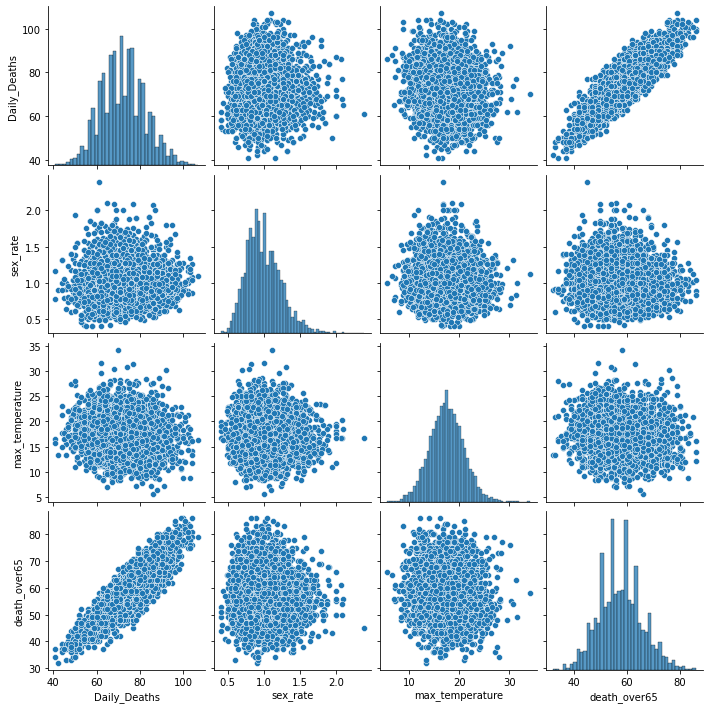

In [43]:
sns.pairplot(newcastle_train.loc[(newcastle_train.month>=6) & (newcastle_train.month<=9), 
                                 ['Daily_Deaths','sex_rate','max_temperature','death_over65']])

In [50]:
newcastle_train_ = newcastle_train.loc[:, ['death_over65','max_temperature','year','month','day']]
newcastle_train_

,death_over65,max_temperature,year,month,day
date,,,,,
1981-01-01,77,4.549093,1981,1,1
1981-01-02,81,0.061612,1981,1,2
1981-01-03,87,2.300846,1981,1,3
1981-01-04,65,6.150383,1981,1,4
1981-01-05,74,7.675478,1981,1,5
...,...,...,...,...,...
2020-12-26,86,6.416586,2020,12,26
2020-12-27,91,4.718904,2020,12,27
2020-12-28,99,10.461271,2020,12,28


In [45]:
plt.rcParams['axes.unicode_minus'] = False  
plt.rcParams['figure.dpi'] = 200  
plt.rcParams['text.color'] = 'black'  
plt.style.use('ggplot')

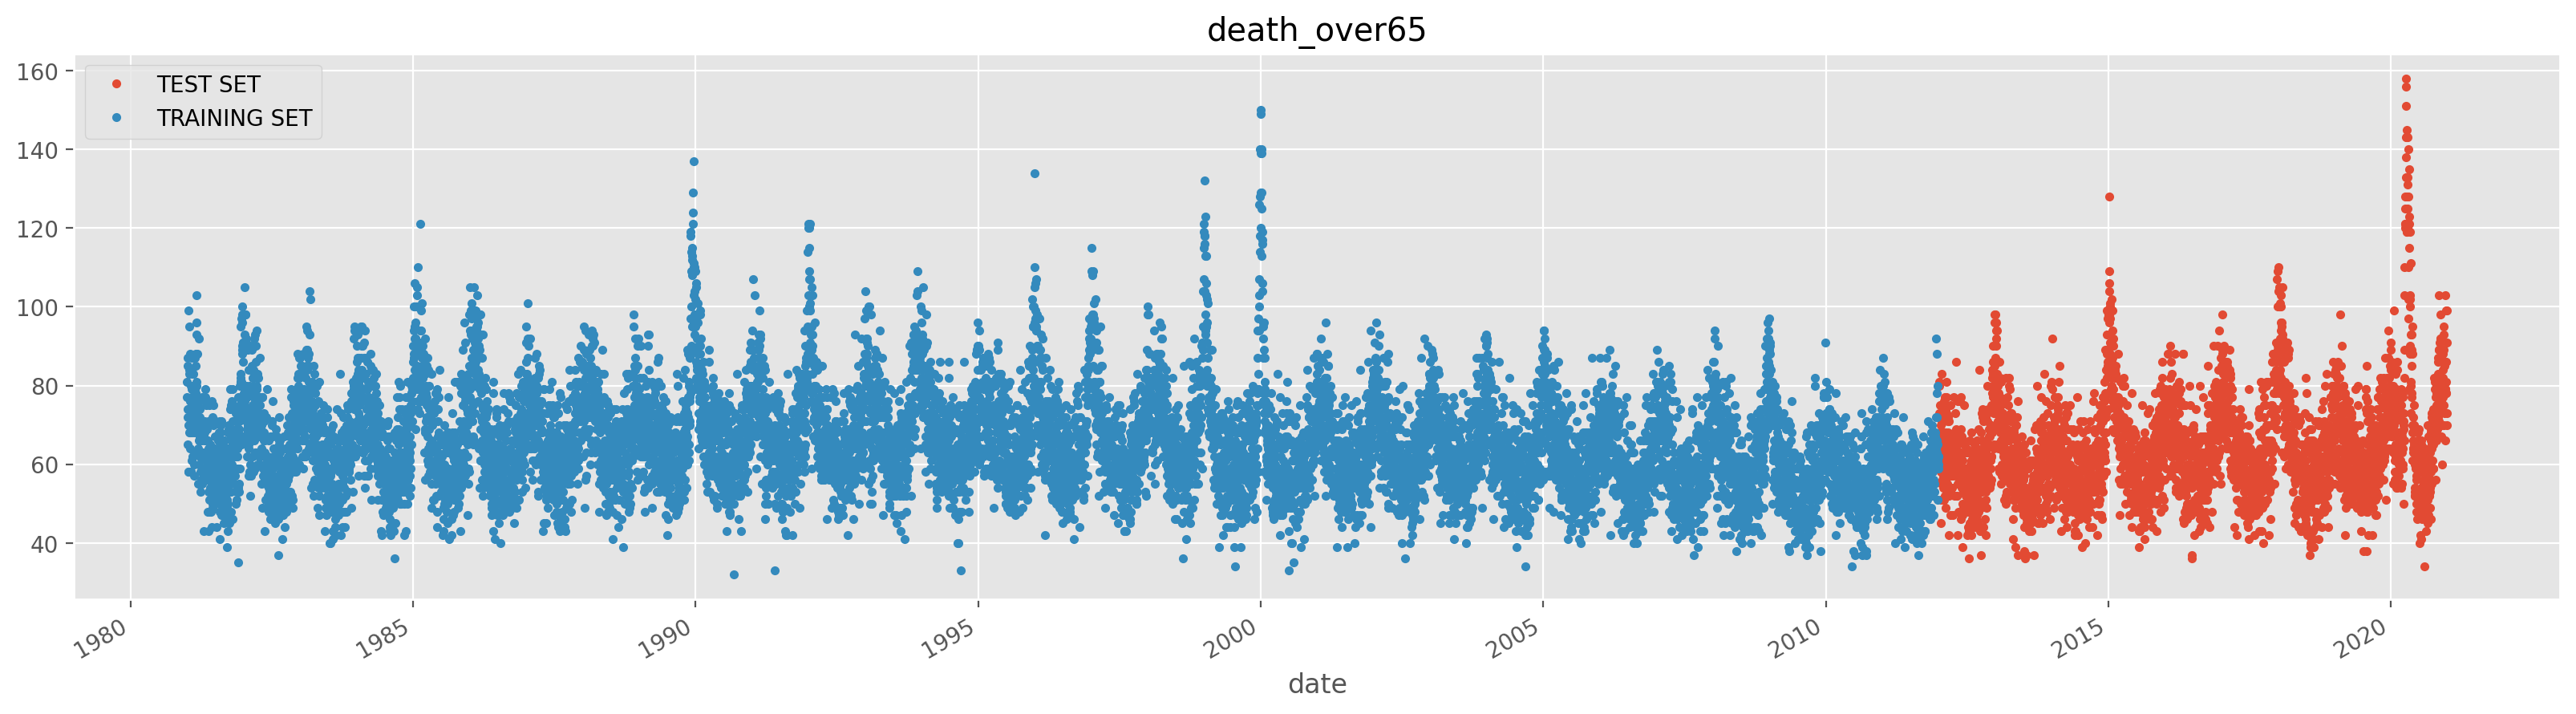

In [52]:
temp = newcastle_train_[['death_over65']]
split_date = '2012-01-01'
temp_train = temp.loc[temp.index <= split_date].copy()
temp_test = temp.loc[temp.index > split_date].copy()
_ = temp_test.rename(columns={'death_over65': 'TEST SET'})\
    .join(temp_train.rename(columns={'death_over65': 'TRAINING SET'}),how='outer') \
    .plot(figsize=(20,5), title='death_over65', style='.')


In [47]:
temp_train = newcastle_train_.loc[newcastle_train_.index < split_date].copy()
temp_test = newcastle_train_.loc[newcastle_train_.index >= split_date].copy()

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb 
from sklearn import model_selection

In [49]:
features = newcastle_train_.drop(['death_over65'], axis = 1) 
targets = newcastle_train_.death_over65

KeyError: "['death_over65'] not found in axis"

In [ ]:
X_train = features.loc[newcastle_train_.index < split_date].copy()
X_train

In [ ]:
X_train_test = features.loc[newcastle_train_.index >= split_date].copy()
X_train_test

In [ ]:
y_train = targets.loc[newcastle_train_.index < split_date].copy()
y_train

In [ ]:
y_train_test = targets.loc[newcastle_train_.index >= split_date].copy()
y_train_test

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
parameters = {
'colsample_bytree':[1.0],
'gamma':[0,0.03,0.1,0.3],
'min_child_weight':[1.0,1.5,6,10],
'learning_rate':[0.3,0.1,0.07,0.001],
'max_depth':[3,5,8,10,50,100],
'n_estimators':[10,100,200,300],
'reg_alpha':[1e-5, 1e-2,  0.75],
'reg_lambda':[1e-5, 1e-2, 0.45],
'subsample':[0.8,0.95]  }
#Lets now fit a XGBOOST model to all the data we have
xgb_new = xgb.XGBRegressor()
gsearch_new = RandomizedSearchCV(estimator=xgb_new, param_distributions=parameters, n_iter=40, scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=2, random_state=1001)
gsearch_new.fit(X_train,y_train)

In [ ]:
print('Best: %f using %s'%(gsearch_new.best_score_, gsearch_new.best_params_))

In [ ]:
model2 = xgb.XGBRegressor(subsample=0.8, reg_lambda=0.45,reg_alpha=1e-05,
                          n_estimators=10, min_child_weight=6, max_depth=5,
                          learning_rate=0.3, gamma=0, colsample_bytree=1.0)
model2.fit(X_train,y_train)

In [ ]:
__ = xgb.plot_importance(model2, height=0.9)

In [ ]:
temp_test['Prediction'] = model2.predict(X_train_test)
temp_all = pd.concat([temp_test, temp_train], sort=False)
__ = temp_all[['death_over65','Prediction']].plot(figsize=(15, 5))


In [ ]:
mse = mean_squared_error(y_true=temp_test['death_over65'], y_pred=temp_test['Prediction'])
# 14.718074529657168
mae = mean_absolute_error(y_true=temp_test['death_over65'], y_pred=temp_test['Prediction'])
# 2.9980725916891813
mape = mean_absolute_percentage_error(y_true=temp_test['death_over65'], y_pred=temp_test['Prediction'])
# inf
# 因为 y_true 中含有 0

In [ ]:
mae

In [ ]:
mse

In [ ]:
mape